In [1]:
# %pip install lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 45.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

In [3]:
# import mnist
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import v2 as T

In [4]:
tfms=T.Compose([
  T.ToTensor(),
  T.Normalize((0.5,),(0.5,))
])

train_ds=datasets.MNIST("./data/mnist",train=True,transform=tfms,download=True)
valid_ds=datasets.MNIST("./data/mnist",train=False,transform=tfms,download=False)

len(train_ds),len(valid_ds)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4168733.32it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134076.04it/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 475203.84it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4578353.47it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



(60000, 10000)

In [5]:
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True,num_workers=2,pin_memory=True)
valid_dl=DataLoader(train_ds,batch_size=128,shuffle=False,num_workers=2,pin_memory=True)

len(train_dl),len(valid_dl)

(938, 469)

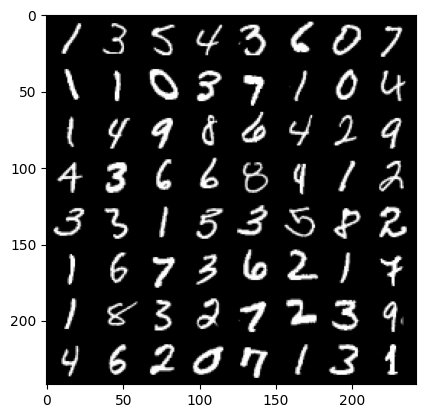

In [7]:
from utils import show_images
for images,_ in train_dl:
  show_images(images)
  break

In [9]:
import itertools

class Block(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(out_features),
            nn.Dropout1d(dropout)
        )

    def forward(self, X: torch.Tensor):
        return self.block(X)


class AutoEncoder(L.LightningModule):
    def __init__(self, encoder_dims: list[int] | tuple[int], decoder_dims: list[int] | tuple[int], dropout=0.2):
        super().__init__()

        encoder = [Block(in_features, out_features, dropout)
                   for in_features, out_features in zip(encoder_dims, encoder_dims[1:])]
        self.encoder = nn.Sequential(*encoder)

        decoder = [Block(in_features, out_features, dropout)
                   for in_features, out_features in zip(decoder_dims, decoder_dims[1:])]
        self.decoder = nn.Sequential(*decoder)

        self.training_step_output = []
        self.validation_step_output = []
        self.epoch=0

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        shape=X.shape
        X = X.view(shape[0],-1)
        X=self.decoder(self.encoder(X))
        X=X.view(shape)
        return X

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
        itertools.chain(self.encoder.parameters(), self.decoder.parameters()),lr=3e-4)
        return optimizer



    def training_step(self, batch):
        X,_=batch
        out = self.forward(X)
        loss = F.mse_loss(X, out)
        self.training_step_output.append(loss)
        return  loss

    def validation_step(self, batch,batch_idx):
        X,_=batch
        # Generate images
        if batch_idx == 0:
          gen_images = self.forward(X)

          # Normalize the generated images to be between 0 and 1
          gen_images = gen_images * 0.5 + 0.5
          grid = make_grid(gen_images, nrow=8)
          self.logger.experiment.add_image("Generated Images Grid", grid, self.current_epoch)

        out = self.forward(X)
        loss = F.mse_loss(X, out)
        self.validation_step_output.append(loss)
        return loss

    def predict_step(self, batch):
        X,_=batch
        out = self.forward(X)
        return out



    def on_train_epoch_end(self) -> None:
        self.on_epoch_end(self.training_step_output, "training_loss")
        print()

    def on_validation_epoch_end(self) -> None:
        self.on_epoch_end(self.validation_step_output, "validation_loss")
        self.epoch+=1


    def on_epoch_end(self, data: list, log_str: str):
        avg_loss = torch.tensor(data).mean()
        print(f"{log_str}: {avg_loss}")
        self.log(log_str, avg_loss)
        # free up the memory
        data.clear()

In [10]:
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
encoder_dims=[28*28,100,50,8]
decoder_dims=[8,100,28*28]

autoencoder=AutoEncoder(encoder_dims,decoder_dims).to(DEVICE)
autoencoder

AutoEncoder(
  (encoder): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=100, bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout1d(p=0.2, inplace=False)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
        (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout1d(p=0.2, inplace=False)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=50, out_features=8, bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
        (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout1d(p=0.2, inplace=False)
      )
    )
  )
  (de

In [12]:
from torchsummary import summary

print("Encoder:\n")
summary(autoencoder.encoder,(28*28,))
print()
print("Decoder:\n")
summary(autoencoder.decoder,(8,))

Encoder:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
         LeakyReLU-2                  [-1, 100]               0
       BatchNorm1d-3                  [-1, 100]             200
         Dropout1d-4                  [-1, 100]               0
             Block-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
         LeakyReLU-7                   [-1, 50]               0
       BatchNorm1d-8                   [-1, 50]             100
         Dropout1d-9                   [-1, 50]               0
            Block-10                   [-1, 50]               0
           Linear-11                    [-1, 8]             408
        LeakyReLU-12                    [-1, 8]               0
      BatchNorm1d-13                    [-1, 8]              16
        Dropout1d-14         

In [ ]:
# import shutil
# shutil.rmtree("logs")

In [15]:
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

logger=TensorBoardLogger("./logs/tensorboard")
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
epochs=12

trainer=Trainer(accelerator=DEVICE,devices='auto',logger=logger,fast_dev_run=False,max_epochs=epochs,enable_progress_bar=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(autoencoder,train_dl,valid_dl)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 84.3 K | train
1 | decoder | Sequential | 81.9 K | train
-----------------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.665     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 84.3 K | train
1 | decoder | Sequential | 81.9 K | train
-----------------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.665     Total estimated model params size (MB)
32        Modules in train mode
0         Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.9338161945343018


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.5952174663543701
training_loss: 1.590341567993164



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.3784633278846741
training_loss: 0.9124643802642822



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.2692071497440338
training_loss: 0.575698733329773



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.22966766357421875
training_loss: 0.4289950430393219



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.21562041342258453
training_loss: 0.3757390081882477



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.21021884679794312
training_loss: 0.362104207277298



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.20325958728790283
training_loss: 0.35893917083740234



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.20137158036231995
training_loss: 0.35789576172828674



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.19944064319133759
training_loss: 0.3535780906677246



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.1963198035955429
training_loss: 0.3545011281967163



Validation: |          | 0/? [00:00<?, ?it/s]

validation_loss: 0.19659526646137238
training_loss: 0.35161155462265015



Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=12` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.


validation_loss: 0.1960473358631134
training_loss: 0.3519153296947479



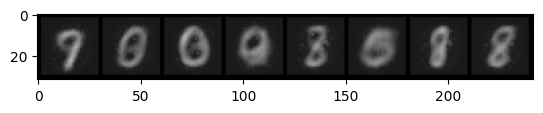

In [20]:
with torch.no_grad():
  autoencoder.eval()
  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  for images,_ in train_dl:
    images=images.to()
    gen_images=autoencoder(images).to(device)
    gen_images=gen_images.detach().to('cpu')
    show_images(gen_images[:8])
    break
  autoencoder.train()